# Data Analytics and Feature Engineering

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

In [1]:
!python --version

In [2]:
import pandas as pd
import numpy as np
import math
import json
import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('assets/portfolio.json', orient='records', lines=True)
profile = pd.read_json('assets/profile.json', orient='records', lines=True)
transcript = pd.read_json('assets/transcript.json', orient='records', lines=True)

from helper.data_cleaning import clean_portfolio, clean_profile, clean_transcript, generate_consumer_trend, \
generate_view_and_complete_day_df, generate_target, get_days_not_affect_by_coupon, cal_avg_spend_without_coupon, \
generate_consumer_spending_couponx, generate_coupon_sensitivity
from helper.plot import plot_hist

## Portfolio

In [3]:
portfolio.set_index('id', inplace=True)
portfolio

,reward,channels,difficulty,duration,offer_type
id,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo


Things that are interesting to us are:

- `difficulty`: how much do you need to spend to trigger the reward;

- `duration`: maximum time for the user to complete the offer;

- `offer_type`: Buy one get one free or just discount

We know that there are 10 different offers, and `8` of them are actually coupons (we don't care about informational).

- Offer types are our `target data`. In the end, we want need a True/False Table for each coupon map to each user

Perform the following steps to preprocess the data.

- Rename "id" to "offer_id"
- Drop "informational" offer type
- One Hot Encode `offer type` and `channels`

In [4]:
portfolio = clean_portfolio('assets/portfolio.json')

In [5]:
portfolio

,reward,difficulty,duration,bogo,discount,email,mobile,web,social
offer_id,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1.0,0.0,1.0,1.0,0.0,1.0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1.0,0.0,1.0,1.0,1.0,1.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1.0,0.0,1.0,1.0,1.0,0.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0.0,1.0,1.0,0.0,1.0,0.0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,0.0,1.0,1.0,1.0,1.0,1.0
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0.0,1.0,1.0,1.0,1.0,1.0
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1.0,0.0,1.0,1.0,1.0,1.0
2906b810c7d4411798c6938adc9daaa5,2,10,7,0.0,1.0,1.0,1.0,1.0,0.0


## Consumer Profile

In [6]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


There are some profile data that is invalid, let's see how many entry are there.

In [7]:
profile.set_index('id', inplace=True)

In [8]:
print(profile[profile['age'] == 118].shape)
print(profile[profile['income'].isnull()].shape)
print(profile[profile['gender'].isnull()].shape)

(2175, 4)
(2175, 4)
(2175, 4)


Histogram of profile

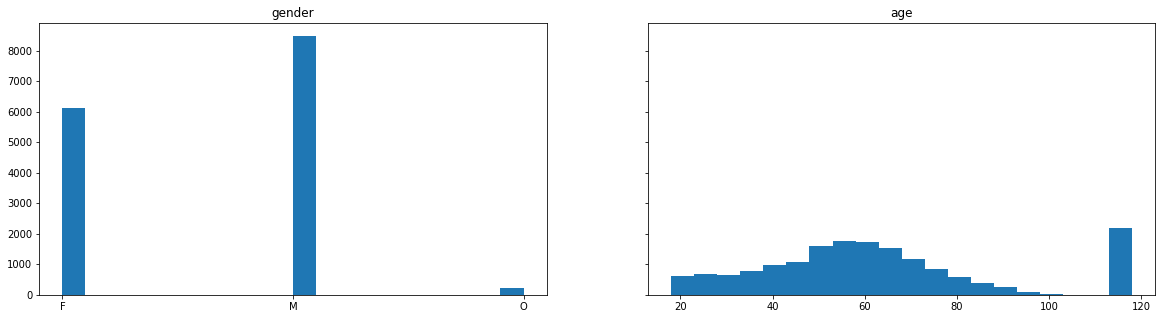

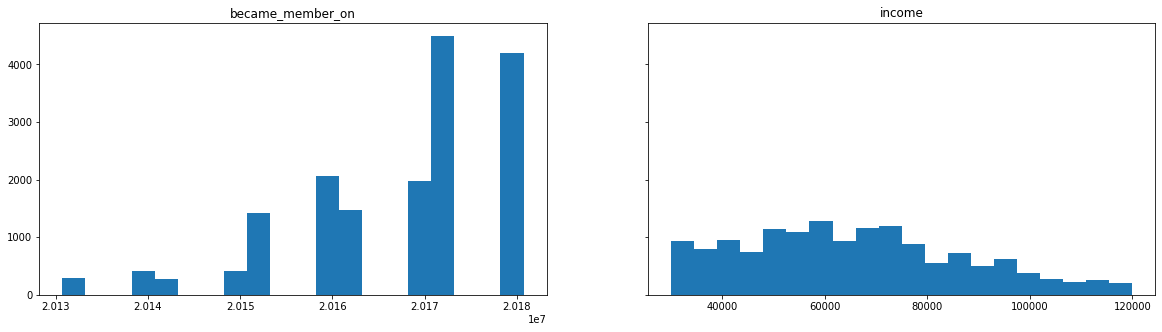

In [9]:
plot_hist(profile)

Perform the following steps to preprocess the data.

- Rename "id" to "consumer_id"
- Drop all `nan` data
- Drop "gender" that are in the `O` catergory
- Split date into `year`, `month`, `day`
- One Hot Encode `date`, `gender`, `age` and `income`

In [10]:
profile = clean_profile('assets/profile.json')

In [11]:
profile.head()

,2013,2014,2015,2016,2017,2018,01,02,03,04,...,30000-40000,40000-50000,50000-60000,60000-70000,70000-80000,80000-90000,90000-100000,100000-110000,110000-120000,120000-130000
consumer_id,,,,,,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
78afa995795e4d85b5d9ceeca43f5fef,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
e2127556f4f64592b11af22de27a7932,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
389bc3fa690240e798340f5a15918d5c,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(profile.shape)

(14613, 40)


## Transcript

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
print(transcript.shape)

(306534, 4)


There are a lot of information we can gain from `transcript` dataframe

let's see what `event` type and `time` mean

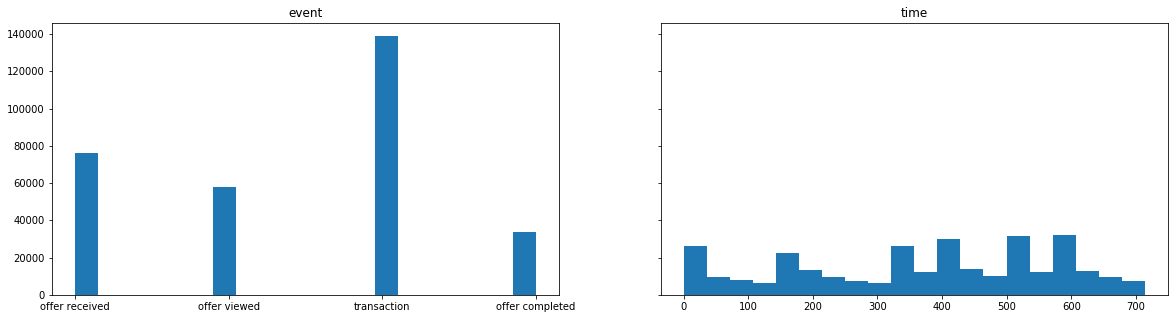

In [15]:
plot_hist(transcript[['event', 'time']])

We can see there are 4 types of events.

- `offer received`

In [16]:
transcript[transcript['event'] == 'offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
transcript[transcript['event'] == 'offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [18]:
transcript[transcript['event'] == 'transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [19]:
transcript[transcript['event'] == 'offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


Here, we can generate two important dataframe.

- #### Target table
    - for each type of coupon, we can calculate if a consumer has successfully complete that offer. Thus we will have a True / False Table.

- #### Consumer Spending Trend
    - For each consumer, we can calculate the consumer's spending trend
    
To achieve our goal, we need to perform the following steps to clean transcript data:

- rename `person` to `consumer_id`
- rename `value` to `offer_id` and reformat the value

In [20]:
transcript = clean_transcript('assets/transcript.json')
transcript

,consumer_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53


## Analyze trend for consumers

We will use the `cleaned_profile` as our user dataset.

We can get all the transaction information. Based on this we can get the daily spending of each consumer

In [21]:
consumer_trend_day_df = generate_consumer_trend(transcript)

In [22]:
consumer_trend_day_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
consumer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,22.16,...,0.0,0.00,14.11,13.56,10.27,0.00,0.00,12.36,28.16,18.41
00116118485d4dfda04fdbaba9a87b5c,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.00,0.00,0.00,0.0,13.49,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,22.05,0.00,23.03,8.96,0.00,0.00
0020c2b971eb4e9188eac86d93036a77,0.0,0.00,49.63,24.39,0.0,0.00,24.31,0.0,0.0,0.00,...,0.0,17.24,33.86,0.00,0.00,0.00,0.00,0.00,0.00,47.43
0020ccbbb6d84e358d3414a3ff76cffd,0.0,16.27,0.00,0.00,0.0,0.00,0.00,0.0,0.0,11.65,...,0.0,0.00,0.00,0.00,0.00,10.32,0.00,0.00,7.47,0.00


We now have the consumer trend of each day.

Save the consumer trend info to `consumer_trend_day.csv`

In [23]:
consumer_trend_day_df.to_csv('assets/consumer_trend_day.csv')

## Target Data
How do we decide if a consumer `SUCCESSFULLY` used a coupon?

Here is the algorithm:

The consumer has to first `view` the coupon and then `complete` the coupon within the allowed time.
We will use the `viewed` and `completed` information from the `transcript` table, then for each `viewed`, we calculate if the consumer `completed` the coupon within its duration.

Perform the following steps:

- Calculate a table on what day does the consumer viewed a specific coupon
- Calculate a table on what day does the consumer completed a specific coupon
- Based on these two table, caculate if the specific coupon is a valid completion, the definition of a valid completion:
    `day of completed - day of viewed < duration`

In [24]:
viewed_trend_day_df, completed_trend_day_df = generate_view_and_complete_day_df(transcript)

In [25]:
print(viewed_trend_day_df.shape)
viewed_trend_day_df.head()

(16907, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
consumer_id,,,,,,,,,,,,,,,,,,,,,
1722b68468334f8fa8ab22180b63d577,,,ae264e3637204a6fb9bb56bc8210ddfd,,,,,,,,...,,,,,,4d5c57ea9a6940dd891ad53e9dbe8da0,,,,
ad43ddab7325414f9f8ffa7331a0f13f,fafdcd668e3743c1bb461111dcafc2a4,,,,,,,,,,...,,,,,,,,,,
240f9e161db24e10bbcc963e3a3f80f9,,,,,,,,,f19421c1d4aa40978ebb69ca19b0e20d,,...,,,,,fafdcd668e3743c1bb461111dcafc2a4,,,,,
65b016b2a4b5404187395c8ca9a8e00d,,,,,,,,,,,...,,,,,fafdcd668e3743c1bb461111dcafc2a4,,,,,
3b9c0f6ce8914161b23a0976c1b4cc38,ae264e3637204a6fb9bb56bc8210ddfd,,,,,,,,,,...,,,,,,,,,,


In [26]:
print(completed_trend_day_df.shape)
completed_trend_day_df.head()

(16907, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
consumer_id,,,,,,,,,,,,,,,,,,,,,
1722b68468334f8fa8ab22180b63d577,,ae264e3637204a6fb9bb56bc8210ddfd,,,,,,,,,...,,f19421c1d4aa40978ebb69ca19b0e20d,,,4d5c57ea9a6940dd891ad53e9dbe8da0,,,,,
ad43ddab7325414f9f8ffa7331a0f13f,,,,,fafdcd668e3743c1bb461111dcafc2a4,,,ae264e3637204a6fb9bb56bc8210ddfd,,,...,,,,,,,,,,
240f9e161db24e10bbcc963e3a3f80f9,,,,,,,,,,,...,,,,,,,,,,
65b016b2a4b5404187395c8ca9a8e00d,,,,,,,,,,,...,,,,,,,,,,
3b9c0f6ce8914161b23a0976c1b4cc38,,,,,,,,,,,...,,,,,,,,,,


In [27]:
target_coupon = generate_target(viewed_trend_day_df, completed_trend_day_df, portfolio)
target_coupon

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
consumer_id,,,,,,,,
1722b68468334f8fa8ab22180b63d577,0,0,0,0,0,0,0,0
ad43ddab7325414f9f8ffa7331a0f13f,0,0,0,0,0,1,0,0
240f9e161db24e10bbcc963e3a3f80f9,0,0,0,0,0,0,0,0
65b016b2a4b5404187395c8ca9a8e00d,0,0,0,0,0,0,0,0
3b9c0f6ce8914161b23a0976c1b4cc38,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
e0a9ee8fae6f497aadbdd28c82aa7484,0,0,0,0,0,0,1,0
6ceaadc496204beb883e5fd9e2da7ae7,0,0,0,0,0,0,0,0
5020a1a69f4c48749526643389e7e8c3,0,1,0,0,0,0,1,0


In [43]:
target_coupon.to_csv('training_data/target.csv')

## Digging more into the trend

Let's take a close look at the spending trend of each consumer.

For example, let's plot the spending activity of consumer `0009655768c64bdeb2e877511632db8f` and consumer `0020ccbbb6d84e358d3414a3ff76cffd`

In [28]:
consumer_1 = consumer_trend_day_df.loc['0009655768c64bdeb2e877511632db8f']
consumer_2 = consumer_trend_day_df.loc['0020ccbbb6d84e358d3414a3ff76cffd']

consumer_1_viewed = list(viewed_trend_day_df.loc['0009655768c64bdeb2e877511632db8f'])
for i, viewed in enumerate(consumer_1_viewed):
    if viewed =='':
        consumer_1_viewed[i] = 0
    else:
        consumer_1_viewed[i] = 10

        
consumer_2_viewed = list(viewed_trend_day_df.loc['0020ccbbb6d84e358d3414a3ff76cffd'])
for i, viewed in enumerate(consumer_2_viewed):
    if viewed =='':
        consumer_2_viewed[i] = 0
    else:
        consumer_2_viewed[i] = 10

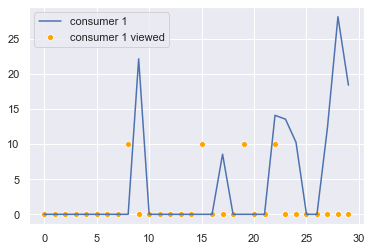

In [29]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.scatterplot(consumer_1.index, consumer_1_viewed, ax=ax, label='consumer 1 viewed', color='orange')
sns.lineplot(consumer_1.index, consumer_1.values, ax=ax, label='consumer 1')

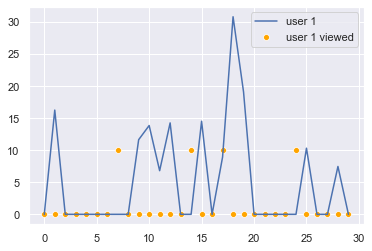

In [30]:
fig, ax = plt.subplots()
sns.scatterplot(consumer_2.index, consumer_2_viewed, ax=ax, label='user 1 viewed', color='orange')
sns.lineplot(consumer_2.index, consumer_2.values, ax=ax, label='user 1')

## Coupon Sensitivity

Based on this data visualization, we can tell the `view` activity has so what a connection to the spending activity:

For these 2 consumer, at least, it looks like `more spending activities are followed by the view acitivity`.

It will be helpful to create a feature to describe this phenomenon - `Coupon Sensitivity`

Here is how it works:

For the duration of the coupon (in the following days), how much `more` does this person spend compare to the purchase that are not initiated by the coupon - those purchases not in the following days of a coupon view event.

Formula for `coupon sensitivity`

`(avg_couponx_effective_spend - avg_spend_without_coupon) / coupon_difficulty`

- avg_couponx_effective_spend: if a consumer views a coupon, if he/she spend in the following days within its duration, these amount are called couponx_effective_spend, we then take the average.

- avg_spend_without_coupon: if a consumer spend on coffee in the days that are not affect by ANY coupon

- coupon difficulty: the difficulty of completing the coupon, this is to normalize each coupon

## Calculate avg_spend_without_coupon

1. getting all non affected by coupon days

In [31]:
days_not_affect_by_coupon = get_days_not_affect_by_coupon(viewed_trend_day_df, portfolio)

In [32]:
days_not_affect_by_coupon

,days_not_affect_by_coupon
consumer_id,
1722b68468334f8fa8ab22180b63d577,"[0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
ad43ddab7325414f9f8ffa7331a0f13f,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2..."
240f9e161db24e10bbcc963e3a3f80f9,"[0, 1, 2, 3, 4, 5, 6, 7, 13, 14, 15]"
65b016b2a4b5404187395c8ca9a8e00d,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3b9c0f6ce8914161b23a0976c1b4cc38,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
...,...
e0a9ee8fae6f497aadbdd28c82aa7484,"[19, 20, 5, 6]"
6ceaadc496204beb883e5fd9e2da7ae7,"[5, 6, 14, 15, 16, 29]"
5020a1a69f4c48749526643389e7e8c3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


2. Calculating each person's `avg_spend_without_coupon`

In [33]:
consumer_sensitivity = cal_avg_spend_without_coupon(consumer_trend_day_df, days_not_affect_by_coupon)
consumer_sensitivity

,avg_spend_without_coupon
consumer_id,
0009655768c64bdeb2e877511632db8f,3.815000
00116118485d4dfda04fdbaba9a87b5c,0.227222
0011e0d4e6b944f998e987f904e8c1e5,1.887778
0020c2b971eb4e9188eac86d93036a77,2.838889
0020ccbbb6d84e358d3414a3ff76cffd,7.570000
...,...
fff3ba4757bd42088c044ca26d73817a,27.953333
fff7576017104bcc8677a8d63322b5e1,1.119444
fff8957ea8b240a6b5e634b6ee8eafcf,0.675000


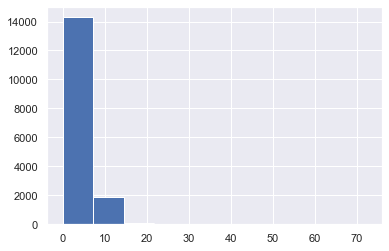

In [34]:
consumer_sensitivity['avg_spend_without_coupon'].hist()

In [35]:
generate_coupon_sensitivity(consumer_sensitivity, viewed_trend_day_df, portfolio, consumer_trend_day_df)
consumer_sensitivity

,avg_spend_without_coupon,ae264e3637204a6fb9bb56bc8210ddfd_type_spend,4d5c57ea9a6940dd891ad53e9dbe8da0_type_spend,9b98b8c7a33c4b65b9aebfe6a799e6d9_type_spend,0b1e1539f2cc45b7b9fa7c272da2e1d7_type_spend,2298d6c36e964ae4a3e7e9706d1fb8c2_type_spend,fafdcd668e3743c1bb461111dcafc2a4_type_spend,f19421c1d4aa40978ebb69ca19b0e20d_type_spend,2906b810c7d4411798c6938adc9daaa5_type_spend,ae264e3637204a6fb9bb56bc8210ddfd_type_sensitivity,4d5c57ea9a6940dd891ad53e9dbe8da0_type_sensitivity,9b98b8c7a33c4b65b9aebfe6a799e6d9_type_sensitivity,0b1e1539f2cc45b7b9fa7c272da2e1d7_type_sensitivity,2298d6c36e964ae4a3e7e9706d1fb8c2_type_sensitivity,fafdcd668e3743c1bb461111dcafc2a4_type_sensitivity,f19421c1d4aa40978ebb69ca19b0e20d_type_sensitivity,2906b810c7d4411798c6938adc9daaa5_type_sensitivity
consumer_id,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,3.815000,0.000000,0.000,0.000000,0.000,0.000000,12.108750,5.534000,0.00000,-0.381500,-0.381500,-0.763000,-0.190750,-0.545000,0.829375,0.343800,-0.381500
00116118485d4dfda04fdbaba9a87b5c,0.227222,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.077778,0.00000,-0.022722,-0.022722,-0.045444,-0.011361,-0.032460,-0.022722,-0.029889,-0.022722
0011e0d4e6b944f998e987f904e8c1e5,1.887778,0.000000,0.000,7.720000,5.404,1.704286,0.000000,0.000000,0.00000,-0.188778,-0.188778,1.166444,0.175811,-0.026213,-0.188778,-0.377556,-0.188778
0020c2b971eb4e9188eac86d93036a77,2.838889,0.000000,3.448,0.000000,0.000,0.000000,9.833000,0.000000,0.00000,-0.283889,0.060911,-0.567778,-0.141944,-0.405556,0.699411,-0.567778,-0.283889
0020ccbbb6d84e358d3414a3ff76cffd,7.570000,0.000000,0.000,2.965000,0.000,6.655714,0.000000,10.860000,0.00000,-0.757000,-0.757000,-0.921000,-0.378500,-0.130612,-0.757000,0.658000,-0.757000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,27.953333,0.000000,0.000,6.381429,0.000,0.000000,13.339000,0.000000,0.00000,-2.795333,-2.795333,-4.314381,-1.397667,-3.993333,-1.461433,-5.590667,-2.795333
fff7576017104bcc8677a8d63322b5e1,1.119444,0.297143,2.100,0.000000,0.000,0.000000,1.338421,0.000000,0.00000,-0.082230,0.098056,-0.223889,-0.055972,-0.159921,0.021898,-0.223889,-0.111944
fff8957ea8b240a6b5e634b6ee8eafcf,0.675000,0.000000,0.000,0.000000,0.000,0.000000,0.809000,0.000000,0.00000,-0.067500,-0.067500,-0.135000,-0.033750,-0.096429,0.013400,-0.135000,-0.067500


## Consumer Sensitivity Visualization

Let's plot the histogram of Consumer Sensitivity

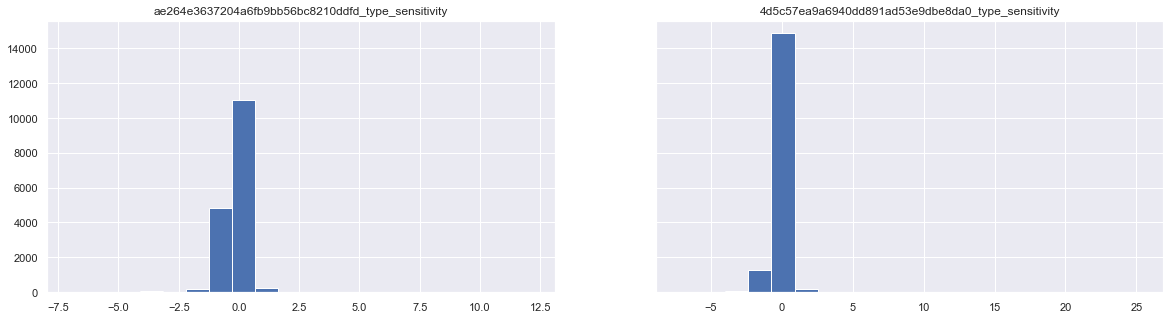

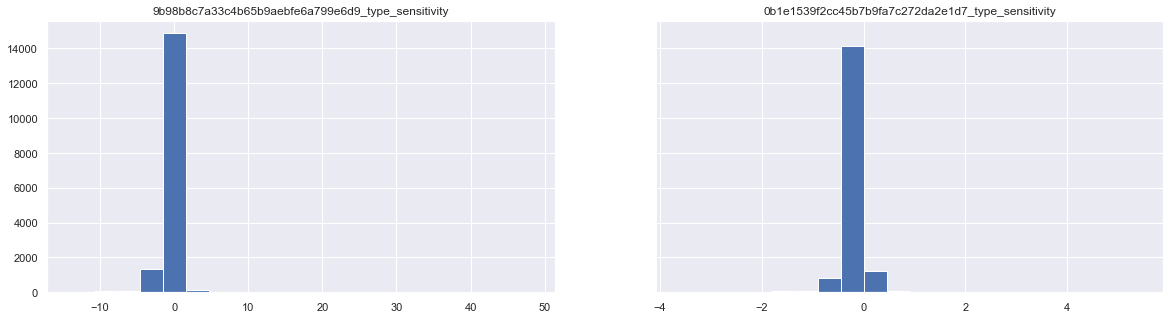

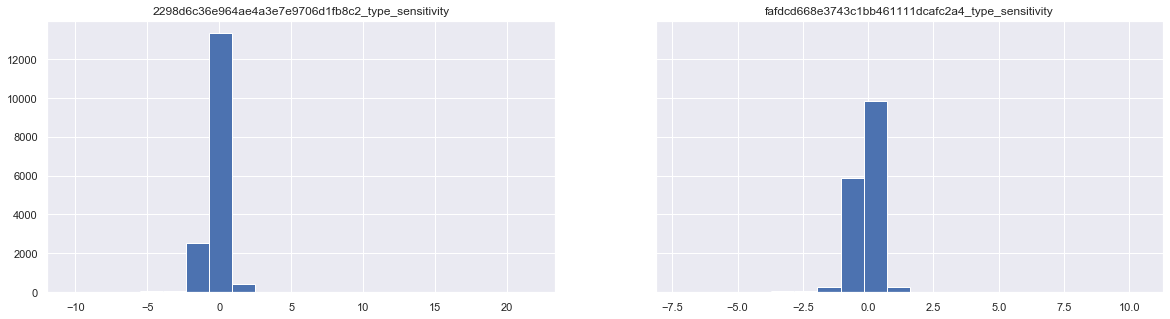

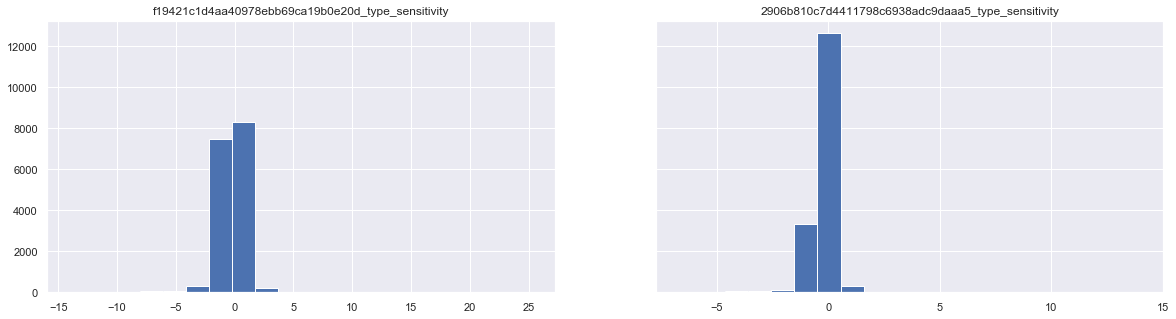

In [41]:
plot_hist(consumer_sensitivity)

In [37]:
consumer_sensitivity.to_csv('training_data/consumer_sensitivity.csv')

## More Features

Now that we have the target information and coupon sensitivity, we need more features to train our model.

Based on the trend, we are able to create more features we think may help the modeling

## Consumer Trend Features

Create a table that contains the following features

- Avg Daily spending: The mean of spending of each day
- Highest daily spending: The max of daily spending
- Lowest daily spending: The min of daily spending
- std_daily_spending: The standard deviation of daily spending
- Count days no spending: The number of days consumer did not spend on starbucks coffee
- count days spending 0_to_5: The number of days consumer spend 0 - 5 on starbucks coffee
- count days spending 5_to_10: The number of days consumer spend 5 - 10 on starbucks coffee
- count days spending 10_to_15: The number of days consumer spend 10 - 15 on starbucks coffee
- count days spending 15_to_20: The number of days consumer spend 15 - 20 on starbucks coffee
- count days spending 20_plus: The number of days consumer spend 20 plus on starbucks coffee

In [39]:
from helper.data_cleaning import generate_consumer_data
feature_group = generate_consumer_data(consumer_trend_day_df)
feature_group.head()

,Avg Daily spending,Highest daily spending,Lowest daily spending,count days no spending,count days spending 0_to_5,count days spending 5_to_10,count days spending 10_to_15,count days spending 15_to_20,count days spending 20_plus,std_daily_spending
consumer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,4.253333,28.16,8.57,22.0,0.0,1.0,1.0,1.0,2.0,7.867232
00116118485d4dfda04fdbaba9a87b5c,0.136333,3.39,0.70,28.0,2.0,0.0,0.0,0.0,0.0,0.627653
0011e0d4e6b944f998e987f904e8c1e5,2.648667,23.03,8.96,25.0,0.0,1.0,1.0,0.0,2.0,6.461309
0020c2b971eb4e9188eac86d93036a77,6.562000,49.63,17.24,24.0,0.0,0.0,0.0,1.0,5.0,14.444319
0020ccbbb6d84e358d3414a3ff76cffd,5.135000,30.84,6.81,19.0,0.0,3.0,3.0,2.0,1.0,7.923300


## Feature Group Visualization

Let's plot the histogram of these data

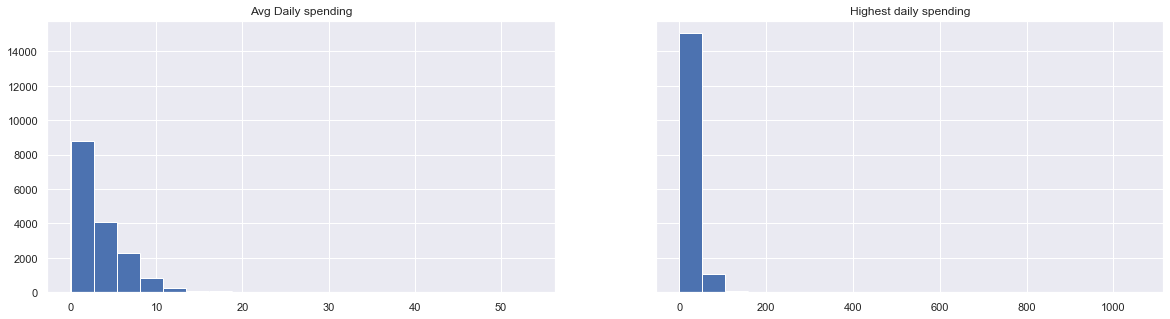

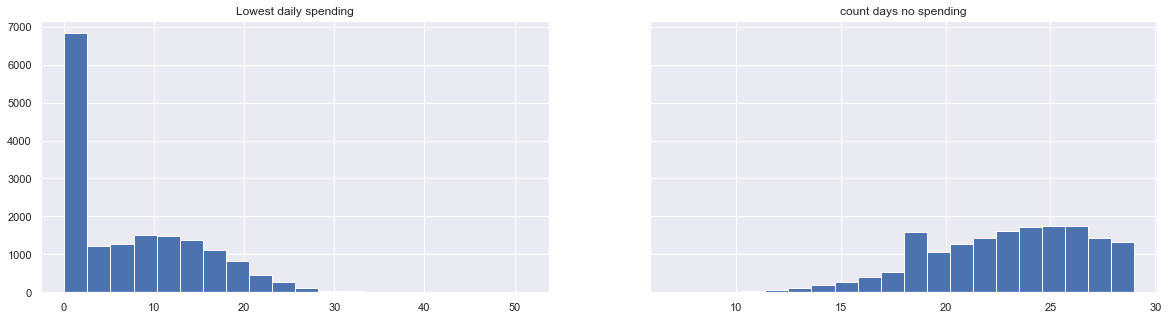

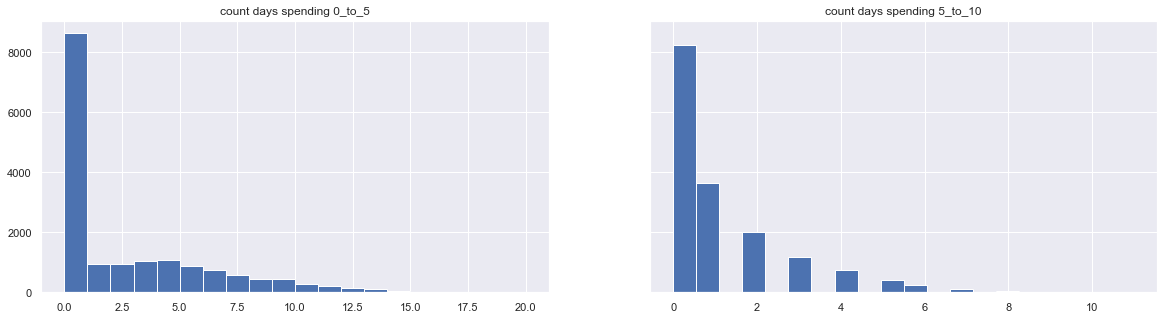

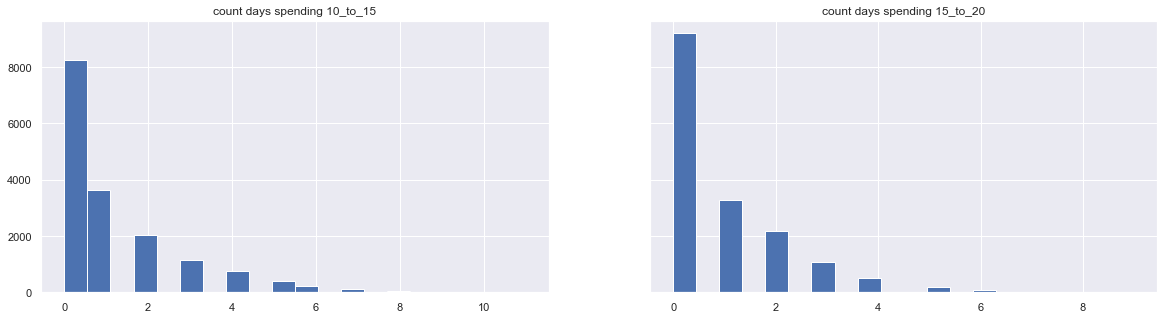

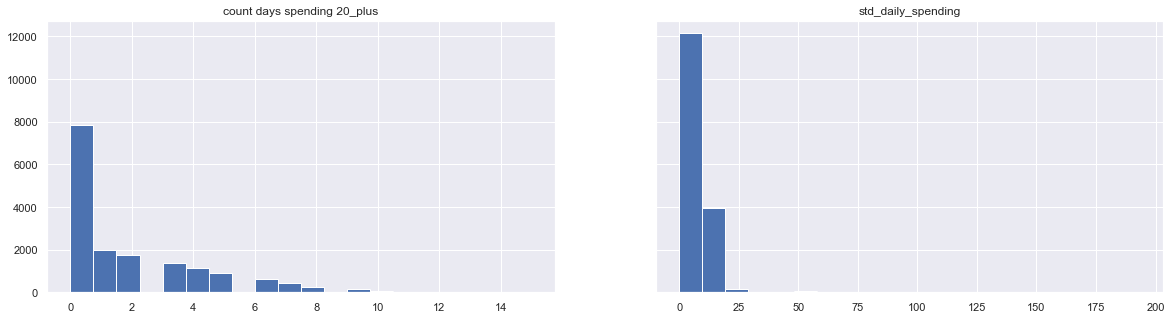

In [40]:
plot_hist(feature_group)

In [42]:
feature_group.to_csv('training_data/consumer_features.csv')